## 1. Objetivos

1. Identificar insights acerca de Gêneros, Atores e Diretores favoritos da plataforma.
2. Obter diferentes baseadas por País de origem da obra.
3. Criar um modelo de Recomendação de filmes a partir da descrição dos mesmos.


## 2. Importando Bibliotecas e Dataset

In [1]:
# Bibliotecas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt # Biblioteca para Streamgraph

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Dataset
from google.colab import drive
drive.mount('/content/drive')
df=pd.read_csv('/content/drive/MyDrive/Datasets/netflix_titles.csv')

Mounted at /content/drive


In [3]:
df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


In [4]:
df.shape

(8807, 12)

In [5]:
df.dtypes

show_id         object
type            object
title           object
director        object
cast            object
country         object
date_added      object
release_year     int64
rating          object
duration        object
listed_in       object
description     object
dtype: object

Irei criar uma cópia do dataset original.

No tratamento e exploração de dados provavelmente eu irei mexer na estrutura dos dados para nos possibilitar entender seus comportamentos.

A cópia do dataset original será utilizada na modelagem do Sistema de Recomendação em si.

In [6]:
df_original = df.copy()

## 3. Tratamento dos dados

A partir da leitura da descrição do Dataset e pelo que é visto acima, é possível detalhar o que significa cada uma das colunas:
- **show_id**: ID de cada título;
- **type**: Categoria do título, podendo ser **filme (Movie)** ou **série (TV show)**;
- **title**: Nome do produto;
- **director**: Nome do diretor do título;
- **cast**: Atores envolvidos no título;
- **country**: País em que o título foi produzido;
- **date_added**: Data em que o título foi incluído no catálogo da Netflix;
- **release_year**: Ano de estreia do título;
- **rating**: Classificação de faixa etária (dentro da lei dos Estados Unidos);
- **duration**: Duração do título, podendo ser em minutos (Movies) ou em temporadas (TV Show);
- **listed_in**: Gênero do título;
- **description**: Sinopse do título.

Antes de começar a análise exploratória, é preciso fazer um tratamento dos dados. 

Inicialmente percebe-se que colunas como 'director', 'cast', 'listed_in' e 'country' em diversos IDs possuem mais de um item. 

Dessa forma, para facilitar as análises, será preciso fazer a separação dos itens, para que cada ID do dataframe contemple apenas 1.

In [7]:
def separate_column(column,name):
  # Transformando coluna em uma lista
  constraint = column.apply(lambda x: str(x).split(', ')).tolist()
  # Gerando um Dataframe a partir da lista criada (cada item da coluna virará uma coluna nova)
  df1 = pd.DataFrame(constraint, index = df['title'])
  # Reshape do Dataframe para torná-lo multi-level, ou seja, as novas colunas se transformam em linhas do df
  df1 = df1.stack()
  # Reset dos IDs para o novo Dataframe gerado
  df1 = pd.DataFrame(df1.reset_index())
  # Renomeando coluna e drop da coluna 'level_1'
  df1.rename(columns={0:name},inplace=True)
  df1 = df1.drop(['level_1'],axis=1)

  return df1


In [8]:
df1 = separate_column(df['director'], 'director')
df1.head(10)

,title,director
0,Dick Johnson Is Dead,Kirsten Johnson
1,Blood & Water,nan
2,Ganglands,Julien Leclercq
3,Jailbirds New Orleans,nan
4,Kota Factory,nan
5,Midnight Mass,Mike Flanagan
6,My Little Pony: A New Generation,Robert Cullen
7,My Little Pony: A New Generation,José Luis Ucha
8,Sankofa,Haile Gerima
9,The Great British Baking Show,Andy Devonshire


In [9]:
df2 = separate_column(df['cast'], 'cast')
df2.head(10)

,title,cast
0,Dick Johnson Is Dead,nan
1,Blood & Water,Ama Qamata
2,Blood & Water,Khosi Ngema
3,Blood & Water,Gail Mabalane
4,Blood & Water,Thabang Molaba
5,Blood & Water,Dillon Windvogel
6,Blood & Water,Natasha Thahane
7,Blood & Water,Arno Greeff
8,Blood & Water,Xolile Tshabalala
9,Blood & Water,Getmore Sithole


In [10]:
df3 = separate_column(df['listed_in'], 'listed_in')
df3.head(10)

,title,listed_in
0,Dick Johnson Is Dead,Documentaries
1,Blood & Water,International TV Shows
2,Blood & Water,TV Dramas
3,Blood & Water,TV Mysteries
4,Ganglands,Crime TV Shows
5,Ganglands,International TV Shows
6,Ganglands,TV Action & Adventure
7,Jailbirds New Orleans,Docuseries
8,Jailbirds New Orleans,Reality TV
9,Kota Factory,International TV Shows


In [11]:
df4 = separate_column(df['country'], 'country')
df4.head(10)

,title,country
0,Dick Johnson Is Dead,United States
1,Blood & Water,South Africa
2,Ganglands,nan
3,Jailbirds New Orleans,nan
4,Kota Factory,India
5,Midnight Mass,nan
6,My Little Pony: A New Generation,nan
7,Sankofa,United States
8,Sankofa,Ghana
9,Sankofa,Burkina Faso


Agora que fizemos a separação das colunas em novos IDs, preciso fazer o merge de todas as bases com o dataframe original.

In [12]:
# Merge dos dataframes gerados
df5 = df2.merge(df1,on=['title'],how='inner')
df6 = df5.merge(df3,on=['title'],how='inner')
df7 = df6.merge(df4,on=['title'],how='inner')

# Merge do novo dataframe gerado com dataframe original
df = df7.merge(df[['show_id', 'type', 'title', 'date_added','release_year', 
                   'rating', 'duration', 'description']], on = ['title'], how='left')
df.head()

,title,cast,director,listed_in,country,show_id,type,date_added,release_year,rating,duration,description
0,Dick Johnson Is Dead,nan,Kirsten Johnson,Documentaries,United States,s1,Movie,"September 25, 2021",2020,PG-13,90 min,"As her father nears the end of his life, filmm..."
1,Blood & Water,Ama Qamata,nan,International TV Shows,South Africa,s2,TV Show,"September 24, 2021",2021,TV-MA,2 Seasons,"After crossing paths at a party, a Cape Town t..."
2,Blood & Water,Ama Qamata,nan,TV Dramas,South Africa,s2,TV Show,"September 24, 2021",2021,TV-MA,2 Seasons,"After crossing paths at a party, a Cape Town t..."
3,Blood & Water,Ama Qamata,nan,TV Mysteries,South Africa,s2,TV Show,"September 24, 2021",2021,TV-MA,2 Seasons,"After crossing paths at a party, a Cape Town t..."
4,Blood & Water,Khosi Ngema,nan,International TV Shows,South Africa,s2,TV Show,"September 24, 2021",2021,TV-MA,2 Seasons,"After crossing paths at a party, a Cape Town t..."


In [13]:
# Shape do dataset final
df.shape

(201991, 12)

In [14]:
# Transformando os strings 'nan' em valores Nulos 
df.replace('nan',np.NaN, inplace=True)

Verificando quantidade de dados faltantes no dataset:

In [15]:
# Print da taxa de valores vazios/nulos por coluna
print((df.isnull().sum()/len(df))*100)

print('-'*100)

# Quantidade de valores únicos por coluna
df.nunique()

title            0.000000
cast             1.062424
director        25.071909
listed_in        0.000000
country          5.889866
show_id          0.000000
type             0.000000
date_added       0.078221
release_year     0.000000
rating           0.033170
duration         0.001485
description      0.000000
dtype: float64
----------------------------------------------------------------------------------------------------


title            8807
cast            36439
director         4993
listed_in          42
country           127
show_id          8807
type                2
date_added       1767
release_year       74
rating             17
duration          220
description      8775
dtype: int64

Temos uma quantidade elevada de dados faltantes nas colunas 'director', 'cast' e 'country'. 

A princípio não farei o drop delas para podermos entender o comportamento delas na análise exploratória.

## 4. Análise Exploratória dos Dados

### Proporção entre 'Movie' e 'TV Show' produzidos

,type,title
0,Movie,6131
1,TV Show,2676


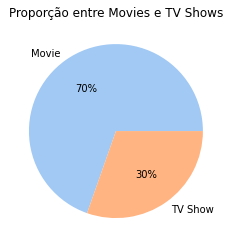

In [16]:
type_count = df.groupby(['type']).agg({'title':'nunique'}).reset_index()
display(type_count)

colors = sns.color_palette('pastel')[0:2]
plt.figure(figsize=(10,4))

plt.pie(type_count['title'], labels = type_count['type'], colors = colors, autopct='%.0f%%')
plt.title('Proporção entre Movies e TV Shows')
plt.show()

Proporção 70:30 entre

### Países com mais títulos produzidos

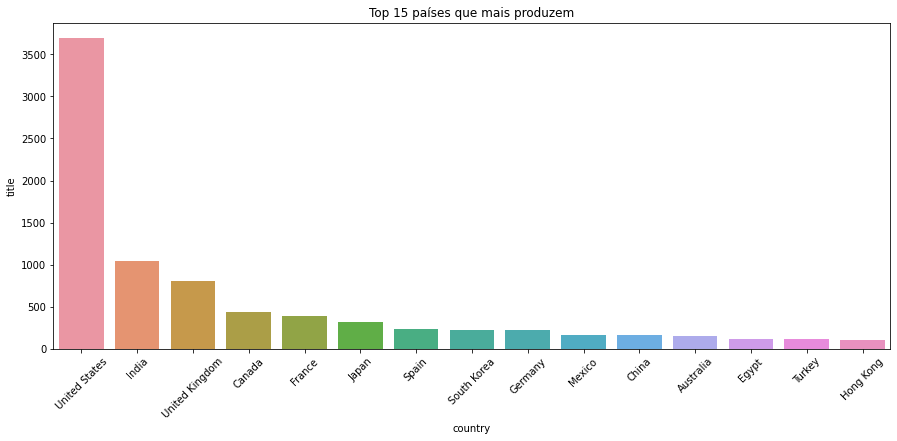

In [17]:
# Usando aggregate (.agg e 'nunique') para pegar valores únicos dos países
country_count=df.groupby(['country']).agg({"title":'nunique'}).reset_index()
country_count = country_count.sort_values(by=['title'],ascending=False)[:15]

plt.figure(figsize=(15,6))
sns.barplot(x = "country",y = 'title', data = country_count)
plt.xticks(rotation = 45)
plt.title('Top 15 países que mais produzem')
plt.show()

In [18]:
# Top 5 Países com mais Títulos
top5 = country_count[:5]
print(top5)

            country  title
119   United States   3689
47            India   1046
117  United Kingdom    804
22           Canada    445
38           France    393


De todos os 8807 conteúdos da coletados no dataset, 3689 (42%) foram produzidos nos EUA.

In [19]:
# Streamgraph com biblioteca altair

year_country = df.groupby('release_year')['country'].value_counts().reset_index(name = 'counts')

year_country = year_country[(year_country['release_year']>= 1990) & (year_country['release_year']< 2020)]

alt.Chart(year_country).mark_area().encode(
    alt.X('release_year'),
    alt.Y('counts:Q', stack = 'center' , axis = None),
    alt.Color('country:N',
             sort = list(top5.index)),
    

).properties(height = 350 , width = 600)

alt.Chart(...)

Estados Unidos produz a maior quantidade de títulos para a plataforma, seguido de India e Reino Unido.

### Gêneros mais produzidos

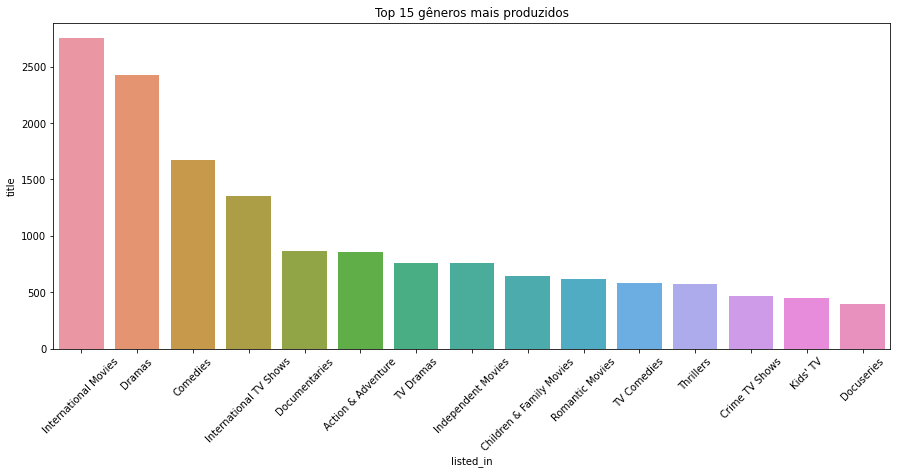

In [20]:
df_genre=df.groupby(['listed_in']).agg({"title":"nunique"}).reset_index().sort_values(by=['title'],ascending=False)[:15]

plt.figure(figsize=(15,6))
sns.barplot(x = "listed_in",y = 'title', data = df_genre)
plt.xticks(rotation = 45)
plt.title('Top 15 gêneros mais produzidos')
plt.show()

Para o top 3 países que mais produzem (USA, India e United Kingdom), quais são os top gêneros mais produzidos?


In [21]:
listedin_count = df.groupby(['country', 'listed_in']).agg({"title":'nunique'}).reset_index()
listedin_count = listedin_count.sort_values(by=['title'],ascending=False)

genre_USA = listedin_count.loc[listedin_count['country'] == 'United States'][:10]
genre_IND = listedin_count.loc[listedin_count['country'] == 'India'][:10]
genre_UK = listedin_count.loc[listedin_count['country'] == 'United Kingdom'][:10]

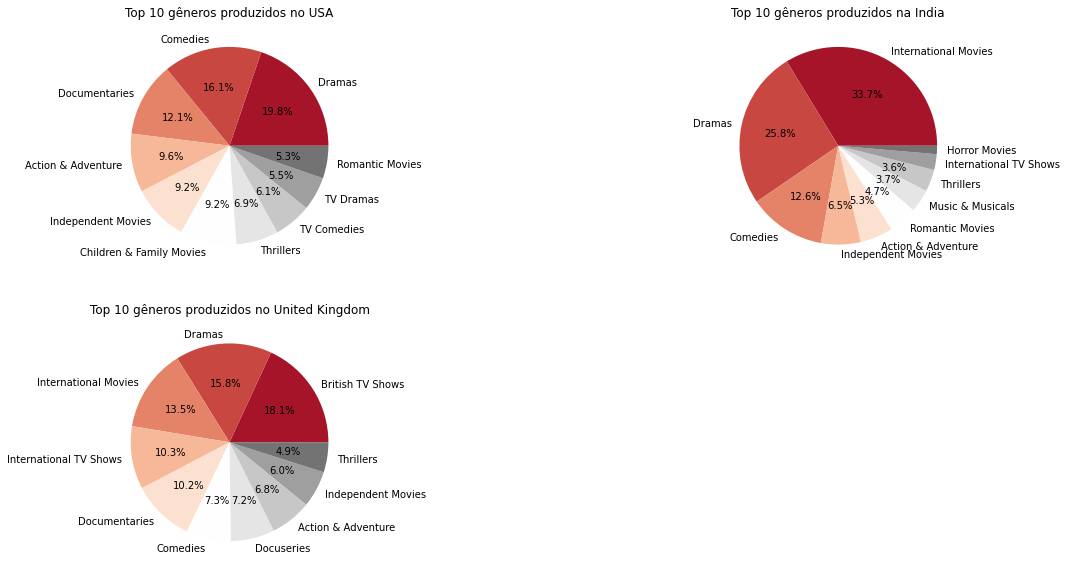

In [22]:
autopct=lambda pct: '{:1.1f}%'.format(pct) if pct >= 3 else ''

plt.figure(figsize=(20,10))
colors = sns.color_palette('RdGy', n_colors=11)

plt.subplot(2,2,1)
plt.pie(genre_USA['title'], labels = genre_USA['listed_in'], colors = colors, autopct=autopct)
plt.title('Top 10 gêneros produzidos no USA')

plt.subplot(2,2,2)
plt.pie(genre_IND['title'], labels = genre_IND['listed_in'], colors = colors, autopct=autopct)
plt.title('Top 10 gêneros produzidos na India')

plt.subplot(2,2,3)
plt.pie(genre_UK['title'], labels = genre_UK['listed_in'], colors = colors, autopct=autopct)
plt.title('Top 10 gêneros produzidos no United Kingdom')

plt.show()

A nomenclatura dos gêneros parece ter sido atribuída de forma centralizada para os Estados Unidos, visto que é onde se encontra a sede do Netflix. É possível verificar essa questão quando os gêneros mais produzidos na India e Reino Unido remetem a características internacionais ou externas ao país ('International Movies' e 'British TV Shows', respectivamente).

Tirando os gêneros que remetem a características externas aos EUA, o estilo de Drama é o mais produzido nos três países.

### Network analysis of Actors / Directors and find interesting insights

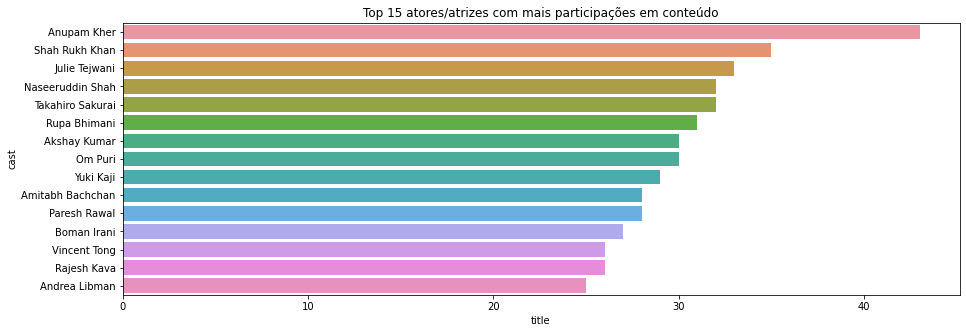

In [23]:
actor_count = df.groupby(['cast']).agg({'title':'nunique'}).reset_index()
actor_count = actor_count.sort_values(by=['title'],ascending=False)[:15]

plt.figure(figsize=(15,5))
sns.barplot(x = "title",y = 'cast', data = actor_count)
plt.title('Top 15 atores/atrizes com mais participações em conteúdo')
plt.show()

Um fato interessante a ser retirado daqui é que não temos nenhum americano nesse TOP 15 de **atores com maiores quantidades de participações em produtos do Netflix**.

O TOP15 acima é composto por 11 Indianos, 2 Japoneses e 2 Canadenses.

Uma especulação para isso, e que talvez mereça um aprofundamento, é que a cultura americana é mais abrangente no âmbito internacional e, por conta disso,o leque de atores/atrizes disponíveis é maior.

A surpreendente presença de 11 pessoas indianas neste ranking parece significar dois pontos:
1. Uma enorme força cultural no âmbito nacional/regional da India.
2. Variedade menor de artistas disponíveis para produtos indianos. 

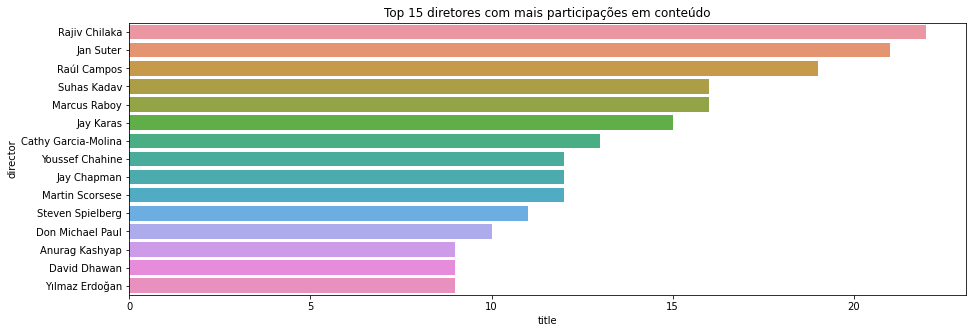

In [24]:
director_count = df.groupby(['director']).agg({'title':'nunique'}).reset_index()
director_count = director_count.sort_values(by=['title'],ascending=False)[:15]

plt.figure(figsize=(15,5))
sns.barplot(x = "title",y = 'director', data = director_count)
plt.title('Top 15 diretores com mais participações em conteúdo')
plt.show()

Em contrapartida ao que foi visto no ranking de atores/atrizes, no TOP15 de diretores temos uma variedade maior de países, a maior parte deles sendo da India e Estados Unidos.

Além destes dois países também foi possível notar nomes de Filipinas, Espanha e México.

Um ponto de atenção para essa visão é que tivemos muitos títulos sem o campo de Diretor preenchido (cerca de 30% do total estava vazio). Portanto existe a possibilidade deste ranking não ser 100% fiel à realidade.

### Filmes produzidos por classificação etária

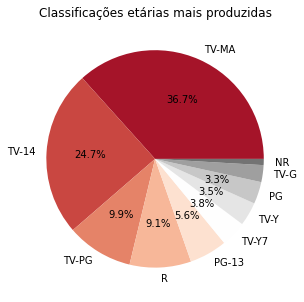

In [25]:
rating_count = df.groupby(['rating']).agg({'title':'nunique'}).reset_index()
rating_count = rating_count.sort_values(by=['title'],ascending=False)[:10]

autopct=lambda pct: '{:1.1f}%'.format(pct) if pct >= 3 else ''

plt.figure(figsize=(15,5))
colors = sns.color_palette('RdGy', n_colors=11)
plt.pie(rating_count['title'], labels = rating_count['rating'], colors = colors, autopct=autopct)
plt.title('Classificações etárias mais produzidas')

plt.show()

Maior parte das produções possuem classificação para audiência madura (acima de 17 anos, conforme leis dos Estados Unidos).

## 5. Modelagem do Sistema de Recomendação

A ideia deste Sistema de Recomendação será gerar uma lista de filmes similares ao selecionado, a partir das informações que temos em mãos (como ator, diretor e sinopse).

Para isso, serão utilizados elementos de Processamento de Linguagem Natural (NLP), como a Tokenização e Vetorização.

Em resumo, o Sistema de Recomendação usará a NLP para analisar as informações do filme/série selecionado e, em seguida, aplicará a técnica de Similaridade por Cossenos para identificar títulos semelhantes.

Em um Sistema de Recomendação ideal, teríamos em mãos as avaliações dos usuários para cada obra, o que nos permitiria ter mais uma forma de melhorar a precisão.

Primeiramente, vou converter todos os strings para letra minúscula, visto que **'A' <> 'a'**

In [26]:
for i in df_original.columns:
  df_original[i] = df_original[i].astype(str)
  df_original[i] = df_original[i].str.lower()
df_original

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,movie,dick johnson is dead,kirsten johnson,nan,united states,"september 25, 2021",2020,pg-13,90 min,documentaries,"as her father nears the end of his life, filmm..."
1,s2,tv show,blood & water,nan,"ama qamata, khosi ngema, gail mabalane, thaban...",south africa,"september 24, 2021",2021,tv-ma,2 seasons,"international tv shows, tv dramas, tv mysteries","after crossing paths at a party, a cape town t..."
2,s3,tv show,ganglands,julien leclercq,"sami bouajila, tracy gotoas, samuel jouy, nabi...",nan,"september 24, 2021",2021,tv-ma,1 season,"crime tv shows, international tv shows, tv act...",to protect his family from a powerful drug lor...
3,s4,tv show,jailbirds new orleans,nan,nan,nan,"september 24, 2021",2021,tv-ma,1 season,"docuseries, reality tv","feuds, flirtations and toilet talk go down amo..."
4,s5,tv show,kota factory,nan,"mayur more, jitendra kumar, ranjan raj, alam k...",india,"september 24, 2021",2021,tv-ma,2 seasons,"international tv shows, romantic tv shows, tv ...",in a city of coaching centers known to train i...
...,...,...,...,...,...,...,...,...,...,...,...,...
8802,s8803,movie,zodiac,david fincher,"mark ruffalo, jake gyllenhaal, robert downey j...",united states,"november 20, 2019",2007,r,158 min,"cult movies, dramas, thrillers","a political cartoonist, a crime reporter and a..."
8803,s8804,tv show,zombie dumb,nan,nan,nan,"july 1, 2019",2018,tv-y7,2 seasons,"kids' tv, korean tv shows, tv comedies","while living alone in a spooky town, a young g..."
8804,s8805,movie,zombieland,ruben fleischer,"jesse eisenberg, woody harrelson, emma stone, ...",united states,"november 1, 2019",2009,r,88 min,"comedies, horror movies",looking to survive in a world taken over by zo...
8805,s8806,movie,zoom,peter hewitt,"tim allen, courteney cox, chevy chase, kate ma...",united states,"january 11, 2020",2006,pg,88 min,"children & family movies, comedies","dragged from civilian life, a former superhero..."


Será criado uma nova coluna onde alocarei todas as informações descritivas do dataset.

Portanto, todas as colunas que não forem características que permitam a identificação de semelhanças entre títulos, serão retiradas nesta etapa.

Devo tomar cuidado para não adicionar o título na coluna descritiva visto que pode gerar vínculo onde não existe. Por exemplo, o filme da "Branca de Neve" não deveria apresentar interseção com "O Abominável Homem das Neves", mesmo que a palavra 'neve' se repita em ambos.

In [27]:
# Drop de colunas
df_original = df_original.drop("show_id", axis=1)
df_original = df_original.drop("date_added", axis=1)
df_original = df_original.drop("duration", axis=1)

In [28]:
df_original['descriptor'] = ''

for i in df_original:
  if i == 'title':
    pass
  else:
    df_original['descriptor'] += df_original[i]+" "

df_original['descriptor']

0       movie kirsten johnson nan united states 2020 p...
1       tv show nan ama qamata, khosi ngema, gail maba...
2       tv show julien leclercq sami bouajila, tracy g...
3       tv show nan nan nan 2021 tv-ma docuseries, rea...
4       tv show nan mayur more, jitendra kumar, ranjan...
                              ...                        
8802    movie david fincher mark ruffalo, jake gyllenh...
8803    tv show nan nan nan 2018 tv-y7 kids' tv, korea...
8804    movie ruben fleischer jesse eisenberg, woody h...
8805    movie peter hewitt tim allen, courteney cox, c...
8806    movie mozez singh vicky kaushal, sarah-jane di...
Name: descriptor, Length: 8807, dtype: object

Com a criação da coluna "descriptor", que possui todas as descrições disponíveis, posso criar um dataframe com apenas o título da obra e o "descriptor"

In [36]:
x = pd.DataFrame(df_original.title)
x["descriptor"] = df_original["descriptor"].astype(str)
x.head()

,title,descriptor
0,dick johnson is dead,movie kirsten johnson nan united states 2020 p...
1,blood & water,"tv show nan ama qamata, khosi ngema, gail maba..."
2,ganglands,"tv show julien leclercq sami bouajila, tracy g..."
3,jailbirds new orleans,"tv show nan nan nan 2021 tv-ma docuseries, rea..."
4,kota factory,"tv show nan mayur more, jitendra kumar, ranjan..."


Import da biblioteca de Tokenização

In [44]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [45]:
# Antes de fazer a tokenização, retirarei as vírgulas e valores 'nan' da nossa coluna de descrição
x["descriptor"] = x["descriptor"].str.replace("nan","")
x["descriptor"] = x["descriptor"].str.replace(",","")
x

,title,descriptor,descriptor_tkn
0,dick johnson is dead,movie kirsten johnson united states 2020 pg-1...,NaN
1,blood & water,tv show ama qamata khosi ngema gail mabalane ...,NaN
2,ganglands,tv show julien leclercq sami bouajila tracy go...,NaN
3,jailbirds new orleans,tv show 2021 tv-ma docuseries reality tv fe...,NaN
4,kota factory,tv show mayur more jitendra kumar ranjan raj ...,NaN
...,...,...,...
8802,zodiac,movie david fincher mark ruffalo jake gyllenha...,NaN
8803,zombie dumb,tv show 2018 tv-y7 kids' tv korean tv shows...,NaN
8804,zombieland,movie ruben fleischer jesse eisenberg woody ha...,NaN
8805,zoom,movie peter hewitt tim allen courteney cox che...,NaN


In [48]:
# Tokenização da descrição
x["descriptor_tkn"] = x.apply(lambda row: word_tokenize(row['descriptor']), axis=1)
x

,title,descriptor,descriptor_tkn
0,dick johnson is dead,movie kirsten johnson united states 2020 pg-1...,"[movie, kirsten, johnson, united, states, 2020..."
1,blood & water,tv show ama qamata khosi ngema gail mabalane ...,"[tv, show, ama, qamata, khosi, ngema, gail, ma..."
2,ganglands,tv show julien leclercq sami bouajila tracy go...,"[tv, show, julien, leclercq, sami, bouajila, t..."
3,jailbirds new orleans,tv show 2021 tv-ma docuseries reality tv fe...,"[tv, show, 2021, tv-ma, docuseries, reality, t..."
4,kota factory,tv show mayur more jitendra kumar ranjan raj ...,"[tv, show, mayur, more, jitendra, kumar, ranja..."
...,...,...,...
8802,zodiac,movie david fincher mark ruffalo jake gyllenha...,"[movie, david, fincher, mark, ruffalo, jake, g..."
8803,zombie dumb,tv show 2018 tv-y7 kids' tv korean tv shows...,"[tv, show, 2018, tv-y7, kids, ', tv, korean, t..."
8804,zombieland,movie ruben fleischer jesse eisenberg woody ha...,"[movie, ruben, fleischer, jesse, eisenberg, wo..."
8805,zoom,movie peter hewitt tim allen courteney cox che...,"[movie, peter, hewitt, tim, allen, courteney, ..."


Count vectorizer vai permitir converter o texto em dados numéricos a partir da frequência das palavras em cada texto.

In [61]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(analyzer = lambda x:x, max_features = 5000, stop_words = "english",token_pattern=r"\b[^\d\W]+\b/g")
cv.fit_transform(x["descriptor_tkn"]).toarray()
matrix = cv.fit_transform(x["descriptor_tkn"])

In [65]:
# Adicionando index 
x.index.name = "index"
x

,title,descriptor,descriptor_tkn
index,,,
0,dick johnson is dead,movie kirsten johnson united states 2020 pg-1...,"[movie, kirsten, johnson, united, states, 2020..."
1,blood & water,tv show ama qamata khosi ngema gail mabalane ...,"[tv, show, ama, qamata, khosi, ngema, gail, ma..."
2,ganglands,tv show julien leclercq sami bouajila tracy go...,"[tv, show, julien, leclercq, sami, bouajila, t..."
3,jailbirds new orleans,tv show 2021 tv-ma docuseries reality tv fe...,"[tv, show, 2021, tv-ma, docuseries, reality, t..."
4,kota factory,tv show mayur more jitendra kumar ranjan raj ...,"[tv, show, mayur, more, jitendra, kumar, ranja..."
...,...,...,...
8802,zodiac,movie david fincher mark ruffalo jake gyllenha...,"[movie, david, fincher, mark, ruffalo, jake, g..."
8803,zombie dumb,tv show 2018 tv-y7 kids' tv korean tv shows...,"[tv, show, 2018, tv-y7, kids, ', tv, korean, t..."
8804,zombieland,movie ruben fleischer jesse eisenberg woody ha...,"[movie, ruben, fleischer, jesse, eisenberg, wo..."


Optarei por usar o método de "Similaridade por Cossenos" para a Recomendação ao invés da "Distância Euclidiana".

Vão existir palavras que aparem mais que as outras e, quanto mais uma palavra aparece, maior ficaria a magnitude do seu vetor, o que influenciaria em um método de Distância Euclidiana.

Na Similaridade por Cossenos, independente do tamanho ou escala do vetor, o que será comparado é a similaridade de ângulação entre eles.

In [73]:
from sklearn.metrics.pairwise import cosine_similarity
similarity_matrix = cosine_similarity(matrix)
similarity_matrix

array([[1.        , 0.05883484, 0.17650452, ..., 0.18257419, 0.17888544,
        0.25819889],
       [0.05883484, 1.        , 0.46153846, ..., 0.19693159, 0.1754116 ,
        0.15191091],
       [0.17650452, 0.46153846, 1.        , ..., 0.19693159, 0.19295276,
        0.30382181],
       ...,
       [0.18257419, 0.19693159, 0.19693159, ..., 1.        , 0.36742346,
        0.21606041],
       [0.17888544, 0.1754116 , 0.19295276, ..., 0.36742346, 1.        ,
        0.25018512],
       [0.25819889, 0.15191091, 0.30382181, ..., 0.21606041, 0.25018512,
        1.        ]])

Abaixo é criada função para enumerar 5 recomendações para um filme desejado do dataset.

In [85]:
def index_title(user_movie):
    movie_index =  x[x["title"] == user_movie]["title"].index[0]
    movies_list = sorted(list(enumerate(similarity_matrix[movie_index])), key=lambda x:x[1], reverse=True)[1:6]
    Recommendations = []
  
    for movie in movies_list:
        Recommendations.append(x.iloc[movie[0]].title)
    return Recommendations

In [83]:
# Top 5 recomendações para "My Little Pony: A New Generation"
index_title("my little pony: a new generation")

['chuchutv bedtime stories & moral stories for kids (english)',
 'chuchutv surprise eggs learning videos (english)',
 'holly star',
 'wish you',
 'yes day']